# TP 3  : Graph Neural Networks Architecture

**Théo Rudkiewicz, Cyriaque Rousselot**

# TUTORIAL

### Install Pytorch Geometric

To handle graph data, we use the library Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/

*   If you use _Google Colab_, simply run the following cell to install Pytorch Geometric (**advised**).
*   If you plan using your _own environment_, follow the documentation to install Pytorch Geometric : https://pytorch-geometric.readthedocs.io/en/latest/install/installation.html and skip the following cell.

In [7]:
########## INSTALL TORCH GEOMETRIC ##################
# https://pytorch-geometric.readthedocs.io/en/latest/
#####################################################
import torch


def format_pytorch_version(version):
    return version.split("+")[0]


TORCH_version = torch.__version__
TORCH = format_pytorch_version(TORCH_version)


def format_cuda_version(version):
    return "cu" + version.replace(".", "")


CUDA_version = torch.version.cuda
CUDA = format_cuda_version(CUDA_version)

!pip install torch-scatter     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-sparse      -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-cluster     -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-spline-conv -f https://pytorch-geometric.com/whl/torch-{TORCH}+{CUDA}.html
!pip install torch-geometric


Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu124.html


### Import required packages

Run the following cell to import all required packages. This cell **must not** be modified.

To significantly accelerate your training, it is advised to use GPU. Using Google Colab, you need to activate it :

*   Edit --> Notebook Setting --> Hardware accelerator --> GPU

In [8]:
#####################################################
################## PACKAGES #########################
#####################################################
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch_geometric.nn as graphnn
from sklearn.metrics import f1_score
from torch_geometric.datasets import PPI
from torch_geometric.loader import DataLoader

### Dataset

We use the Protein-Protein Interaction (PPI) network dataset which includes:
- 20 graphs for training
- 2 graphs for validation
- 2 graphs for testing

One graph of the PPI dataset has on average 2372 nodes. Each node has:
- 50 features : positional gene sets / motif gene / immunological signatures ...
- 121 (binary) labels : gene ontology sets (way to classify gene products like proteins).

**This problem aims to predict, for a given PPI graph, the correct nodes' labels**.

**It is a node (multi-label) classification task** (trained using supervised learning, with labels to be predicted for each node).

For your curiosity, more detailed information on the dataset and some applications:
- https://cs.stanford.edu/~jure/pubs/pathways-psb18.pdf
- https://arxiv.org/abs/1707.04638

To understand how a graph data is implemented in Pytorch Geometric, refer to : https://pytorch-geometric.readthedocs.io/en/latest/get_started/introduction.html


In [9]:
### LOAD DATASETS

BATCH_SIZE = 2

# Train Dataset
train_dataset = PPI(root="", split="train")
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE)
# Val Dataset
val_dataset = PPI(root="", split="val")
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
# Test Dataset
test_dataset = PPI(root="", split="test")
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# Number of features and classes
n_features, n_classes = train_dataset[0].x.shape[1], train_dataset[0].y.shape[1]

print("Number of samples in the train dataset: ", len(train_dataset))
print("Number of samples in the val dataset: ", len(test_dataset))
print("Number of samples in the test dataset: ", len(test_dataset))
print("Output of one sample from the train dataset: ", train_dataset[0])
print("Edge_index :")
print(train_dataset[0].edge_index)
print("Number of features per node: ", n_features)
print("Number of classes per node: ", n_classes)

Number of samples in the train dataset:  20
Number of samples in the val dataset:  2
Number of samples in the test dataset:  2
Output of one sample from the train dataset:  Data(x=[1767, 50], edge_index=[2, 32318], y=[1767, 121])
Edge_index :
tensor([[   0,    0,    0,  ..., 1744, 1745, 1749],
        [ 372, 1101,  766,  ..., 1745, 1744, 1739]])
Number of features per node:  50
Number of classes per node:  121


### Define a basic Model

Here we define a very simple Graph Neural Network model which will be used as our baseline. This model consists of three graph convolutional layers (from https://arxiv.org/pdf/1609.02907.pdf). The first two layers computes 256 features, followed by an ELU activation function. The last layer is used for (multi-label) classification task, computing 121 features (for each node).

In [10]:
#####################################################
################## MODEL ############################
#####################################################
class BasicGraphModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()

        self.graphconv1 = graphnn.GCNConv(input_size, hidden_size)
        self.graphconv2 = graphnn.GCNConv(hidden_size, hidden_size)
        self.graphconv3 = graphnn.GCNConv(hidden_size, output_size)

        self.elu = nn.ELU()

    def forward(self, x, edge_index):
        x = self.graphconv1(x, edge_index)
        x = self.elu(x)
        x = self.graphconv2(x, edge_index)
        x = self.elu(x)
        x = self.graphconv3(x, edge_index)

        return x

Next function is designed to evaluate the performance of the model, computing the F1-Score

In [11]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

Next we construct the function to train the model.

In [12]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader):
    epoch_list = []
    scores_list = []

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            logits = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(logits, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            scores_list.append(score)
            epoch_list.append(epoch)

    return epoch_list, scores_list

Let's train this model !

In [13]:
### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

### Max number of epochs
max_epochs = 200

### DEFINE THE MODEL
basic_model = BasicGraphModel(input_size=n_features, hidden_size=256, output_size=n_classes).to(
    device
)

### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss()

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(basic_model.parameters(), lr=0.005)

### TRAIN THE MODEL
epoch_list, basic_model_scores = train(
    basic_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
)


Device:  cuda


Epoch 00001 | Loss: 0.6374
F1-Score: 0.4518
Epoch 00002 | Loss: 0.5805
Epoch 00003 | Loss: 0.5626
Epoch 00004 | Loss: 0.5552
Epoch 00005 | Loss: 0.5504
Epoch 00006 | Loss: 0.5456
F1-Score: 0.5151
Epoch 00007 | Loss: 0.5420
Epoch 00008 | Loss: 0.5379
Epoch 00009 | Loss: 0.5340
Epoch 00010 | Loss: 0.5308
Epoch 00011 | Loss: 0.5280
F1-Score: 0.5137
Epoch 00012 | Loss: 0.5253
Epoch 00013 | Loss: 0.5229
Epoch 00014 | Loss: 0.5206
Epoch 00015 | Loss: 0.5183
Epoch 00016 | Loss: 0.5160
F1-Score: 0.5333
Epoch 00017 | Loss: 0.5137
Epoch 00018 | Loss: 0.5115
Epoch 00019 | Loss: 0.5093
Epoch 00020 | Loss: 0.5072
Epoch 00021 | Loss: 0.5050
F1-Score: 0.5459
Epoch 00022 | Loss: 0.5030
Epoch 00023 | Loss: 0.5009
Epoch 00024 | Loss: 0.4989
Epoch 00025 | Loss: 0.4970
Epoch 00026 | Loss: 0.4951
F1-Score: 0.5550
Epoch 00027 | Loss: 0.4934
Epoch 00028 | Loss: 0.4915
Epoch 00029 | Loss: 0.4898
Epoch 00030 | Loss: 0.4882
Epoch 00031 | Loss: 0.4869
F1-Score: 0.5631
Epoch 00032 | Loss: 0.4861
Epoch 00033 | Los

Let's evaluate the performance of this basic model

Basic Model : F1-Score on the validation set: 0.6493


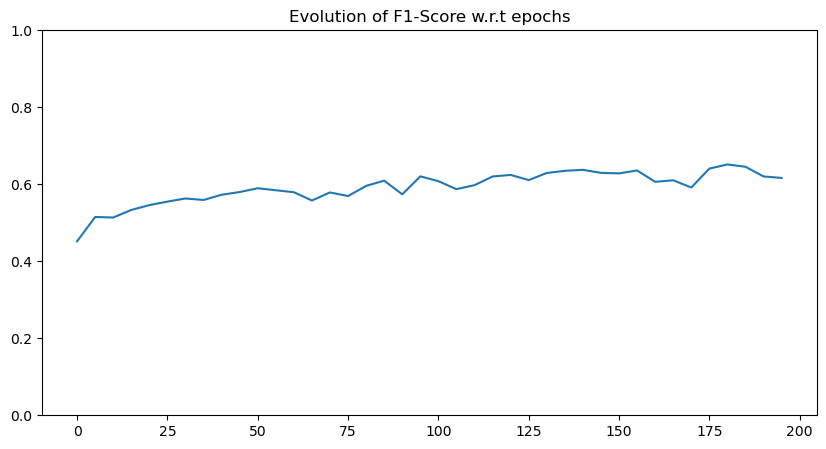

In [14]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(basic_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.show()


plot_f1_score(epoch_list, basic_model_scores)

# QUESTIONS

## Grading

You will be graded on 5 questions. You will need to provide at least 4 files :
1. This Notebook
2. `class_model_gnn.py`
3. `model.pth` (the file **must be of size less than 50Mo** but 20Mo should be enough to get a very good model)
4. `conv_as_message_passing.py`

If the function you defined passes all the tests, you will get the full grade. Otherwise we  will look at the intermediate questions in the notebook to give you partial credit.



 Please provide clear, short and __bold font__ answers.  

> Question 1 : Design, build and train a model with a F1-score higher than 93% on validation set (**HINT :** https://arxiv.org/pdf/1710.10903.pdf).


 Provide two files : (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
 -  a file  `class_model_gnn.py` containing the class inheriting from `torch.nn.Module` architecture of your final model to load
 -  a `model.pth` file : the model weights

 We will  test your model on final F1-Score on a test set. You must not use the test set for hyperparameter training.

Intermediate question :

 Provide the script for training, and a plot of the training loss.  

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F


# Define model ( in your class_model_gnn.py)

# class Graph_Attention_Model(nn.Module):
#     def __init__(self,input_size,hidden_size,n_features):
#         super(Graph_Attention_Model, self).__init__()
#         self.gat_1=graphnn.GATConv(input_size, hidden_size,4) #attention to get 1024 features, 4 attention heads
#         self.gat_2=graphnn.GATConv(4*hidden_size, hidden_size,4) #attention to get 1024 features 4 attention heads
#         self.gat_3=graphnn.GATConv(4*hidden_size,n_features,6,concat=False) # to get 121 features with 6 attention heads
#         self.lin_1=nn.Linear(input_size,4*hidden_size)
#         self.lin_2=nn.Linear(4*hidden_size,4*hidden_size)
#         self.lin_3=nn.Linear(4*hidden_size,n_features)
#         self.elu=nn.ELU()
#         #Glorot init for each gat
#         self.init_weights()

#     def init_weights(self):
#         for module in self.modules():
#             if isinstance(module, graphnn.GATConv):
#                 if hasattr(module, 'lin'):
#                     nn.init.xavier_uniform_(module.lin.weight)
#                     if module.lin.bias is not None:
#                         nn.init.zeros_(module.lin.bias)
#                 if hasattr(module, 'att'):
#                     nn.init.xavier_uniform_(module.att)


#     def forward(self, x, edge_index):
#         x = F.elu(self.gat_1(x, edge_index) + self.lin_1(x))
#         x = F.elu(self.gat_2(x, edge_index) + self.lin_2(x))
#         x = self.gat_3(x, edge_index) + self.lin_3(x)
#         return x

# # Initialize model
# from class_model_gnn import Graph_Attention_Model

# model = Graph_Attention_Model(input_size=n_features, hidden_size=256, n_features=n_class).to(device)
# ## Save the model
# torch.save(model.state_dict(), "model.pth")

# ### This is the part we will run in the inference to grade your model
# ## Load the model
# model = Graph_Attention_Model()  # !  Important : No argument
# model.load_state_dict(torch.load("model.pth", weights_only=True))
# model.eval()
# print("Model loaded successfully")

In [16]:
#####################################################
############### TEST FUNCTION #######################
#####################################################
def evaluate(model, loss_fcn, device, dataloader):
    score_list_batch = []

    model.eval()
    for i, batch in enumerate(dataloader):
        batch = batch.to(device)
        output = model(batch.x, batch.edge_index)
        loss_test = loss_fcn(output, batch.y)
        predict = np.where(output.detach().cpu().numpy() >= 0, 1, 0)
        score = f1_score(batch.y.cpu().numpy(), predict, average="micro")
        score_list_batch.append(score)

    return np.array(score_list_batch).mean()

In [17]:
#####################################################
############## TRAIN FUNCTION #######################
#####################################################
def train(model, loss_fcn, device, optimizer, max_epochs, train_dataloader, val_dataloader,patience):
    epoch_list = []
    scores_list = []
    best_val_f1 = 0.0
    patience_counter = 0

    # loop over epochs
    for epoch in range(max_epochs):
        model.train()
        losses = []
        # loop over batches
        for i, train_batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            train_batch_device = train_batch.to(device)
            # logits is the output of the model
            outputs = model(train_batch_device.x, train_batch_device.edge_index)
            # compute the loss
            loss = loss_fcn(outputs, train_batch_device.y)
            # optimizer step
            loss.backward()
            optimizer.step()
            losses.append(loss.item())
        loss_data = np.array(losses).mean()
        print("Epoch {:05d} | Loss: {:.4f}".format(epoch + 1, loss_data))

        if epoch % 5 == 0:
            # evaluate the model on the validation set
            # computes the f1-score (see next function)
            score = evaluate(model, loss_fcn, device, val_dataloader)
            print("F1-Score: {:.4f}".format(score))
            if score > best_val_f1:
                best_val_f1 = score
                patience_counter = 0
                torch.save(model.state_dict(), "model.pth")
            else:
                patience_counter += 1
            scores_list.append(score)
            epoch_list.append(epoch)
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

    return epoch_list, scores_list

In [18]:
from class_model_gnn import StudentModel

### DEVICE GPU OR CPU : will select GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("\nDevice: ", device)

max_epochs = 100  # or any high value
patience = 100     # number of epochs to wait before stopping if no improvement


### DEFINE THE MODEL
gat_model= StudentModel(input_size=n_features, hidden_size=256, n_features=n_classes).to(
    device
)
### DEFINE LOSS FUNCTION
loss_fcn = nn.BCEWithLogitsLoss() # applies the sigmoid from the paper

### DEFINE OPTIMIZER
optimizer = torch.optim.Adam(gat_model.parameters(), lr=0.005) # lr from the paper

### TRAIN THE MODEL
epoch_list, gat_model_scores = train(
    gat_model,
    loss_fcn,
    device,
    optimizer,
    max_epochs,
    train_dataloader,
    val_dataloader,
    patience
)


Device:  cuda
Epoch 00001 | Loss: 1.0253
F1-Score: 0.4400
Epoch 00002 | Loss: 0.6043
Epoch 00003 | Loss: 0.5359
Epoch 00004 | Loss: 0.5070
Epoch 00005 | Loss: 0.4837
Epoch 00006 | Loss: 0.4627
F1-Score: 0.5652
Epoch 00007 | Loss: 0.4412
Epoch 00008 | Loss: 0.4186
Epoch 00009 | Loss: 0.3963
Epoch 00010 | Loss: 0.3723
Epoch 00011 | Loss: 0.3584
F1-Score: 0.6763
Epoch 00012 | Loss: 0.3296
Epoch 00013 | Loss: 0.3027
Epoch 00014 | Loss: 0.2748
Epoch 00015 | Loss: 0.2497
Epoch 00016 | Loss: 0.2281
F1-Score: 0.8167
Epoch 00017 | Loss: 0.2073
Epoch 00018 | Loss: 0.1882
Epoch 00019 | Loss: 0.1723
Epoch 00020 | Loss: 0.1605
Epoch 00021 | Loss: 0.1536
F1-Score: 0.8905
Epoch 00022 | Loss: 0.1362
Epoch 00023 | Loss: 0.1201
Epoch 00024 | Loss: 0.1087
Epoch 00025 | Loss: 0.0997
Epoch 00026 | Loss: 0.0928
F1-Score: 0.9267
Epoch 00027 | Loss: 0.0874
Epoch 00028 | Loss: 0.0833
Epoch 00029 | Loss: 0.0824
Epoch 00030 | Loss: 0.0805
Epoch 00031 | Loss: 0.0833
F1-Score: 0.9297
Epoch 00032 | Loss: 0.0806
Ep

In [19]:
# save model
torch.save(gat_model.state_dict(), "model.pth")

Basic Model : F1-Score on the validation set: 0.9753


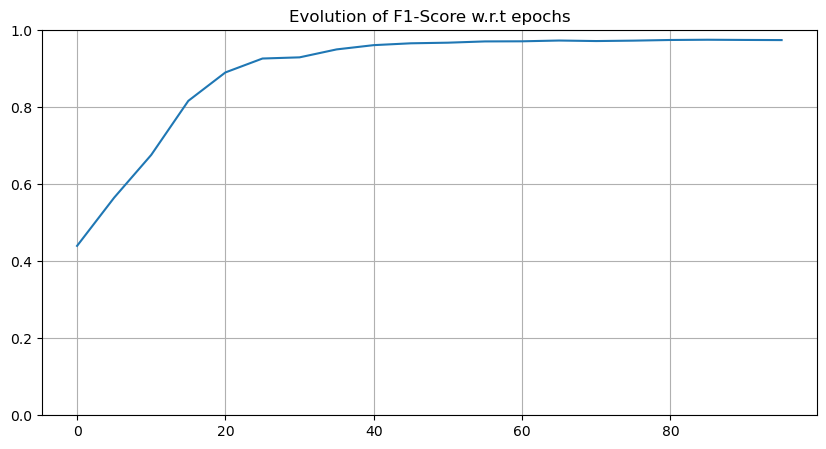

In [20]:
### F1-SCORE ON VALID DATASET
score_valid = evaluate(gat_model, loss_fcn, device, val_dataloader)
print("Basic Model : F1-Score on the validation set: {:.4f}".format(score_valid))


### PLOT EVOLUTION OF F1-SCORE W.R.T EPOCHS
def plot_f1_score(epoch_list, scores):
    plt.figure(figsize=[10, 5])
    plt.plot(epoch_list, scores)
    plt.title("Evolution of F1-Score w.r.t epochs")
    plt.ylim([0.0, 1.0])
    plt.grid()
    plt.show()

plot_f1_score(epoch_list, gat_model_scores)

## Conv 2D as Message Passing Neural Network


## Introduction

The use of graph is a way to structure data by adding neighborhood information between features. This then allows to do operations on the data that are local to each node and its neighbors. This is the main idea behind Graph Neural Networks (GNNs). [`pytorch-geometric`](https://pytorch-geometric.readthedocs.io/en/latest/) is a library compatible with PyTorch that allows to easily implement GNNs. The most general structure is the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) class that is then used as a base for more specific GNNs as seen in the course ([Graph Convolutional Networks](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GCNConv.html#torch_geometric.nn.conv.GCNConv) or [Graph AttenTion Convolution](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.GATConv.html#torch_geometric.nn.conv.GATConv)).

On the other hand, you already know an operation that uses the structure of the data to do local operations: the convolution (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html). One can see the convolution as a specific case of the message passing neural network. The goal of this notebook is to show how to use the `MessagePassing` class to implement a convolutional neural network.
You will be asked to implement 3 functions. You should give back those three functions in a file named `conv_as_message_passing.py`. These functions will then be automatically tested. So be sure to respect the function signature and the function name.


## Assumptions

To make the implementation easier we will make some assumptions:
- the input is a single image (batch size of 1) of size 'C x H x W'
- the convolution will be a 3x3 kernel with stride 1 and padding 1.

You may also assume that the Conv2D layer has no bias but it will be slightly penalized in the grading.

Bonus points will be given if you can handle the cases that are not covered by those assumptions.


## Questions

### Question 2

> Using the formalism used in the [`MessagePassing`](https://pytorch-geometric.readthedocs.io/en/latest/generated/torch_geometric.nn.conv.MessagePassing.html#torch_geometric.nn.conv.MessagePassing) documentation (and on [wikipedia](https://en.wikipedia.org/wiki/Graph_neural_network#Message_passing_layers) with sligthly different notations), explain how theorically you can simulate a 2D convolution using the `MessagePassing` formalism. This may include a pre-processing step to transform the image into a graph and then a post-processing step to transform the graph back into an image. (:warning: Those steps should be independent of the parameters of the convolution, but not necessarily from the hyper-parameters.)
$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$


HINT : It is possible to do it with the following $\gamma$ :

$$ \gamma_\Theta : x,y \mapsto y $$


The idea is to see a standard 2D convolution as a specific case of message passing. When you usually do convolutions, for each pixel you compute a weighted sum over a fixed local neighborhood (e.g., a 3×3 patch). In the message passing formalism, this operation can be split into three steps:

Pre-processing (Image to Graph):

- Nodes: Each pixel becomes a node in the graph.
- Edges: For every pixel i, you create edges from every neighboring pixel j within the convolution kernel (for a 3×3 kernel, this would be the 8 surrounding pixels; often a self-loop is added as well).
Edge Attributes: The edge attribute $e_{ji}$ encodes the relative spatial offset of the neighbor j with respect to the central pixel i (for example, $(−1,−1)$ for the top-left neighbor).

Let's decompose the message passing formula :

$$\mathbf{x}_{i}^{\prime} = \gamma_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\bigoplus\limits_{j \in \mathcal{N}(i)}\,\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right) \right),$$

We need to design a message passing function $\phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{j,i} \right)$ that will multiply the neighbor’s $x_j$ feature by a weight corresponding to its relative position (extracted from the convolution kernel) wrt to the central point $x_i$. That is:

$$ \phi_{\mathbf{\Theta}}\left( \mathbf{x}_{i},\mathbf{x}_{j},\mathbf{e}_{ji} \right) = w(e_{ji}) x_j$$

where $w(e_{ji})$ is the kernel weight for the offset encoded in the edge feature $e_{ji}$​.

The aggregation operation is the summation over all neighboring nodes, which is exactly what a convolution does when summing the weighted contributions.

Taking the update function :

$$ \gamma_{\mathbf{\Theta}} (x,y) = y$$

which means that after aggregating the messages, you directly output the result. This is exactly the convolution operation where the final value at a pixel is just the weighted sum over its receptive field.

Finally the last step is a post processing step which is transforming the image back to the graph.
Once the message passing layer has computed the new node features (which correspond to the convolved pixel values), a post-processing step reorganizes these node features back into the spatial grid of the original image.

In [21]:
import torch
import torch_geometric

### Question 3

> Implement the pre-processing function, you can use the follwing code skeleton (you may change the output type, it is just a strong suggestion):

In [22]:
def image_to_graph(
    image: torch.Tensor, conv2d: torch.nn.Conv2d | None = None
) -> torch_geometric.data.Data:
    """
    Converts an image tensor to a PyTorch Geometric Data object.

    Each pixel becomes a node (with features from the image’s channels), and
    an edge is added from a pixel to each of its 3x3 neighborhood pixels (if within bounds).
    Additionally, the relative offset (di, dj) is stored as edge attributes.

    Arguments:
    ----------
    image : torch.Tensor
        Image tensor of shape (C, H, W).
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None.
        Its parameters (padding, kernel_size, stride) are used for consistency checks.

    Returns:
    --------
    torch_geometric.data.Data
        Graph representation of the image.
    """
    # Assumptions (remove for bonus)
    assert image.dim() == 3, f"Expected 3D tensor, got {image.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    C, H, W = image.shape
    # (C, H, W) to (H*W, C)
    x = image.permute(1, 2, 0).reshape(-1, C)

    edge_index_list = []
    edge_attr_list = []
    
    # we create one "padding node" that will be used to link the border pixels to it.
    # this generic padding node has null features, so it will not be involved in the
    # kernel computation.
    data_padding_node = torch.zeros((1, C))
    id_padding_node = H * W  # linear index for the padding node, just after the last image pixel
    x = torch.cat([x, data_padding_node], dim=0)  # add the padding node to the features    

    # For each pixel at (i, j) (source node)
    for i in range(H):
        for j in range(W):
            src = i * W + j  # linear index for the source node
            # Loop over the 3x3
            for di in [-1, 0, 1]:
                ni = i + di
                for dj in [-1, 0, 1]:
                    nj = j + dj
                    # checking where the neighboring pixel is:
                    
                    # ... first case : within bounds
                    if 0 <= ni < H and 0 <= nj < W:
                        dst = ni * W + nj  # linear index for the neighbor
                    # ... second case : out of bounds, need padding
                    else:
                        dst = id_padding_node
                        
                    # add edge from neighbor to source
                    edge_index_list.append([dst, src])
                    # Save the relative offset as edge attribute,
                    # will be used to find the right kernel weight
                    edge_attr_list.append([di, dj])

    # tensors
    edge_index = torch.tensor(edge_index_list, dtype=torch.long).t().contiguous()  # shape: (2, num_edges)
    edge_attr = torch.tensor(edge_attr_list, dtype=torch.float)  # shape: (num_edges, 2)

    # Create and return the Data object
    data = torch_geometric.data.Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    return data

### Question 4

> Implement the post-processing function, you can use the follwing code skeleton:

In [23]:
import torch
from torch_geometric.data import Data

def graph_to_image(
    data: torch.Tensor, height: int, width: int, conv2d: torch.nn.Conv2d | None = None
) -> torch.Tensor:
    """
    Converts a graph representation of an image to an image tensor.

    Assumes the graph node features 'data' is a 2D tensor of shape (H*W, C) where each row
    corresponds to the features of a pixel.

    Arguments:
    ----------
    data : torch.Tensor
        Graph data representation of the image (node features), expected shape: (H*W, C).
    height : int
        Height of the image.
    width : int
        Width of the image.
    conv2d : torch.nn.Conv2d, optional
        Conv2d layer to simulate, by default None.
        (Used only for consistency checks on padding, kernel_size, and stride.)

    Returns:
    --------
    torch.Tensor
        Image tensor of shape (C, H, W).
    """
    # Assumptions (remove for bonus)
    assert data.dim() == 2, f"Expected 2D tensor, got {data.dim()}D tensor."
    if conv2d is not None:
        assert conv2d.padding[0] == conv2d.padding[1] == 1, "Expected padding of 1 on both sides."
        assert conv2d.kernel_size[0] == conv2d.kernel_size[1] == 3, "Expected kernel size of 3x3."
        assert conv2d.stride[0] == conv2d.stride[1] == 1, "Expected stride of 1."

    # channels
    C = data.size(1)
    # remove the padding node at the last position
    data_without_padding = data[:-1]
    # (H*W, C) to (H, W, C)
    image = data_without_padding.view(height, width, C)
    # Permute to (C, H, W) to get the original format
    image = image.permute(2, 0, 1)
    
    return image

#### Recommended test cases

We **encourage** you to test that you have the property that the pre-processing function followed by the post-processing function is the identity function.

In [24]:
C=5
H=10
W=11

ref_conv = torch.nn.Conv2d(5, 7, kernel_size=3, padding=1, stride=1)
image = torch.randn(5, 10, 11)
g_image = image_to_graph(image, ref_conv)
reconstructed_image = graph_to_image(g_image.x, 10, 11, ref_conv)
assert torch.allclose(image, reconstructed_image)

print(f"The image of size {H} x {W} with {C} channels was encoded into a graph of {H*W} nodes plus one padding node : total {g_image.x.size()}, each with features of dimension {C}")

print(f"\nimage = {image.size()}")
print(f"reconstructed_image = {reconstructed_image.size()}")

The image of size 10 x 11 with 5 channels was encoded into a graph of 110 nodes plus one padding node : total torch.Size([111, 5]), each with features of dimension 5

image = torch.Size([5, 10, 11])
reconstructed_image = torch.Size([5, 10, 11])


### Question 5

> Implement the `Conv2dMessagePassing` class that will simulate a 2D convolution using the `MessagePassing` formalism.
You should inherit from the `MessagePassing` class and only change the `__init__` and `message` functions (the `forward` function has already been changed for you). You should use the following code skeleton:

In [25]:
class Conv2dMessagePassing(torch_geometric.nn.MessagePassing):
    """
    A Message Passing layer that simulates a given Conv2d layer.
    """

    def __init__(self, conv2d: torch.nn.Conv2d):
        # Don't forget to call the parent constructor with the correct aguments
        # we need aggr='add' as we will be adding the messages along the node feature dimension
        assert conv2d.bias is not None, "Conv2d layer should have bias=True"
        
        super(Conv2dMessagePassing, self).__init__(aggr='add')
        # storing the kernel weights and bias
        # the kernel weight is a tensor of shape (out_channels, in_channels, kernel_size[0], kernel_size[1])
        # ... cad ici (out_channels, node_feature_dimension, 3, 3)
        self.kernel_weights = conv2d.weight.data
        # the bias is a tensor of shape (out_channels), mais n'existe que si conv2d a été instancié avec bias=True
        self.bias = conv2d.bias.data  # shape (out_channels,)
        self.bias = self.bias / (conv2d.kernel_size[0] * conv2d.kernel_size[1])  # correct the bias for the sum

    def forward(self, data):
        self.edge_index = data.edge_index

        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        out = self.propagate(edge_index, x=x, edge_attr=edge_attr)
        return out

    def message(self, x_j: torch.Tensor, edge_attr: torch.Tensor) -> torch.Tensor:
        """
        Computes the message to be passed for each edge.
        For each edge e = (u, v) in the graph indexed by i,
        the message through the edge e (ie from node u to node v)
        should be returned as the i-th line of the output tensor.
        (The message is phi(u, v, e) in the formalism.)
        To do this you can access the features of the source node
        in x_j[i] and the attributes of the edge in edge_attr[i].

        Arguments:
        ----------
        x_j : torch.Tensor
            The features of the souce node for each edge (of size E x in_channels).
        edge_attr : torch.Tensor
            The attributes of the edge (of size E x edge_attr_dim).

        Returns:
        --------
        torch.Tensor
            The message to be passed for each edge (of size E x out_channels ??)
        """
        
        # messages should be a tensor of size #edges x #channels_out
        messages = torch.zeros(x_j.size(0), self.kernel_weights.size(0))
        # loop over edges
        for e in range(x_j.size(0)):         
            # get the source node features
            x = x_j[e]  # size (in_channels,)
            # get the relative offset of the edge
            di, dj = edge_attr[e] # values in [-1, 0, 1]
            # compute indices to get the kernel weights
            id_i = di + 1
            id_i = id_i.int()
            id_j = dj + 1
            id_j = id_j.int()
            # compute the message
            # self.kernel_weights est de taille (out_channels, in_channels, kernel_size[0], kernel_size[1])
            # x est de taille (in_channels,)
            msg = torch.mul(self.kernel_weights[:, :, id_i, id_j], x) # output is of size (out_channels, in_channels)
            # msg = msg + self.bias  # add the bias, output is of size(out_channels, in_channels)
            msg = msg.sum(dim=1) # sum over the in_channels dimension, output is of size(out_channels,)
            msg = msg + self.bias  # add the bias, output is of size(out_channels, in_channels). NB : the bias has been divided by the number of messages !
            messages[e] = msg
            
        return messages

## Test example

In [26]:
from conv_as_message_passing import image_to_graph, graph_to_image, Conv2dMessagePassing

c = 5
h = 10
w = 11

ref_conv = torch.nn.Conv2d(c, 2, kernel_size=3, padding=1, stride=1, bias=True)
image = torch.randn(c, h, w)
g_image = image_to_graph(image, ref_conv)
ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)

conv_mp = Conv2dMessagePassing(ref_conv)
g_image = conv_mp(g_image)

y_th = ref_conv(image)

ref_conv.weight.data = torch.randn_like(ref_conv.weight.data)
reconstructed_image = graph_to_image(g_image, h, w, ref_conv)

assert torch.allclose(y_th, reconstructed_image, atol=1e-4)